# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
#!git clone https://github.com/parth1620/Person-Re-Id-Dataset

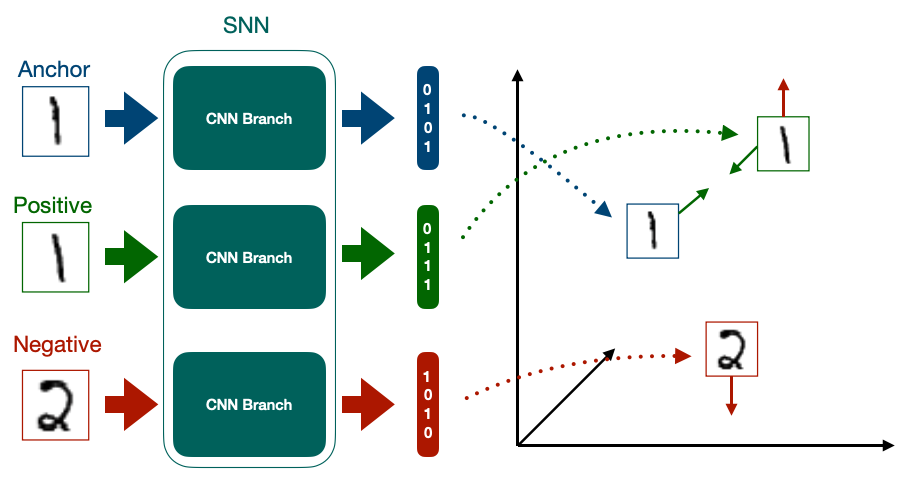

# Imports

In [12]:
import sys
sys.path.append('D:\Desktop\Siamese Network\Siamese-Network\Dataset')

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch


import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [14]:
DATA_DIR = 'D:/Desktop/Siamese Network/Siamese-Network/Dataset/train'
CSV_FILE = 'D:/Desktop/Siamese Network/Siamese-Network/Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cpu'

In [15]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [16]:
import cv2

row = df.iloc[7]
A_img = cv2.imread(DATA_DIR + '/' + row.Anchor)
A_img = cv2.cvtColor(A_img, cv2.COLOR_BGR2RGB)
P_img = cv2.imread(DATA_DIR + '/' + row.Positive)
P_img = cv2.cvtColor(P_img, cv2.COLOR_BGR2RGB)  
N_img = cv2.imread(DATA_DIR + '/' + row.Negative)
N_img = cv2.cvtColor(N_img, cv2.COLOR_BGR2RGB)

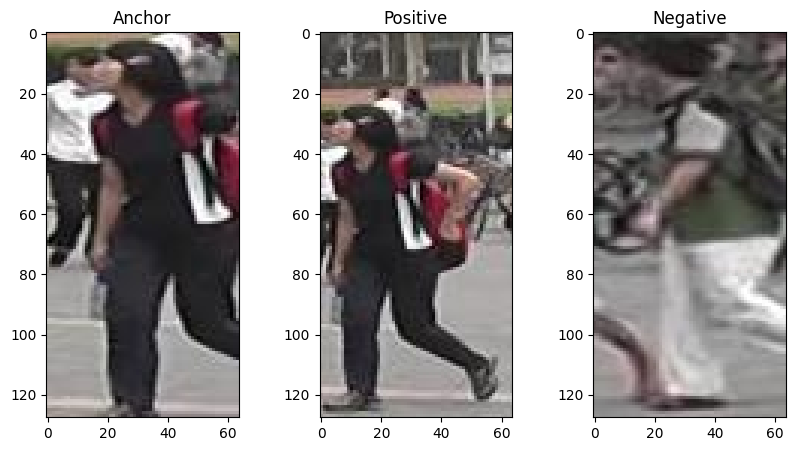

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,5))

ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [18]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Create APN Dataset

In [19]:
class APN_Dataset(Dataset):
	def __init__(self,df):
		self.df =df
	def __len__(self):
		return len(self.df)
	def __getitem__(self, idx):
		row = self.df.iloc[idx]
		A_img = cv2.imread(DATA_DIR + '/' + row.Anchor)
		A_img = cv2.cvtColor(A_img, cv2.COLOR_BGR2RGB)
		P_img = cv2.imread(DATA_DIR + '/' + row.Positive)
		P_img = cv2.cvtColor(P_img, cv2.COLOR_BGR2RGB)
		N_img = cv2.imread(DATA_DIR + '/' + row.Negative)
		N_img = cv2.cvtColor(N_img, cv2.COLOR_BGR2RGB)

		A_img = torch.from_numpy(A_img).permute(2, 0, 1)/255.0
		P_img = torch.from_numpy(P_img).permute(2, 0, 1)/255.0
		N_img = torch.from_numpy(N_img).permute(2, 0, 1)/255.0

		return A_img, P_img, N_img

In [20]:
train_set = APN_Dataset(train_df)
valid_set = APN_Dataset(valid_df)

print(f"size of training set: {len(train_set)}")
print(f"size of validation set: {len(valid_set)}")

size of training set: 3200
size of validation set: 800


In [11]:
idx = 40
A,P,N = train_set[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

RuntimeError: Numpy is not available

# Load Dataset into Batches

In [38]:
trainloader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(valid_set, batch_size = BATCH_SIZE)

In [39]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [41]:
for A, P, N in trainloader:
	break

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [45]:
class APN_Model(nn.Module):
   
	def __init__(self, emb_size = 512):
		super(APN_Model, self).__init__()
		self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
		self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features = emb_size)

	def forward(self, images):
		embeddings = self.efficientnet(images)
		return embeddings 

In [47]:
model = APN_Model()
model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw):

# Create Train and Eval function

In [54]:
def train_fn(model, dataloader, optimizer, criterion):
	model.train() #ON Dropout
	total_loss = 0.0
   
	for A, P, N in tqdm(dataloader):
		A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

		A_embs = model(A)
		P_embs = model(P)
		N_embs = model(N)

		loss = criterion(A_embs, P_embs, N_embs)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss += loss.item()

	return total_loss / len(dataloader)

In [55]:
def valid_fn(model, dataloader, criterion):
	model.eval() #OFF Dropout
	total_loss = 0.0
   
	with torch.no_grad():
		for A, P, N in tqdm(dataloader):
			A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

			A_embs = model(A)
			P_embs = model(P)
			N_embs = model(N)

			loss = criterion(A_embs, P_embs, N_embs)

			total_loss += loss.item()

		return total_loss / len(dataloader)

In [56]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Create Training Loop

In [57]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
	train_loss = train_fn(model, trainloader, optimizer, criterion)
	valid_loss = valid_fn(model, validloader, criterion)
   
	if valid_loss < best_valid_loss:
		torch.save(model.state_dict(), 'best_model.pth')
		best_valid_loss = valid_loss
		print("Weight saved succesfully")

	print(f"Epoch : {i+1} train loss : {train_loss} valid loss : {valid_loss}")   

100%|██████████| 25/25 [00:12<00:00,  1.95it/s]


Weight saved succesfully
Epoch : 1 train loss : 0.45251511693000795 valid loss : 0.2706813171505928


100%|██████████| 25/25 [00:07<00:00,  3.21it/s]


Weight saved succesfully
Epoch : 2 train loss : 0.15303204208612442 valid loss : 0.22364054828882218


100%|██████████| 25/25 [00:07<00:00,  3.34it/s]


Weight saved succesfully
Epoch : 3 train loss : 0.09268367685377597 valid loss : 0.19565512657165526


100%|██████████| 25/25 [00:08<00:00,  3.04it/s]


Weight saved succesfully
Epoch : 4 train loss : 0.07721861347556114 valid loss : 0.18163780152797698


100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Epoch : 5 train loss : 0.09463519006967544 valid loss : 0.21992733418941499


100%|██████████| 25/25 [00:07<00:00,  3.23it/s]


Epoch : 6 train loss : 0.0792250955849886 valid loss : 0.1939625310897827


100%|██████████| 25/25 [00:07<00:00,  3.17it/s]


Weight saved succesfully
Epoch : 7 train loss : 0.04057666771113873 valid loss : 0.13982364118099214


100%|██████████| 25/25 [00:07<00:00,  3.17it/s]


Epoch : 8 train loss : 0.045213129743933676 valid loss : 0.1719886714220047


100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


Epoch : 9 train loss : 0.02472841665148735 valid loss : 0.1881879198551178


100%|██████████| 25/25 [00:07<00:00,  3.22it/s]


Weight saved succesfully
Epoch : 10 train loss : 0.040955550819635395 valid loss : 0.13240885198116303


100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


Epoch : 11 train loss : 0.024532817155122757 valid loss : 0.16106331884860992


100%|██████████| 25/25 [00:07<00:00,  3.26it/s]


Weight saved succesfully
Epoch : 12 train loss : 0.037298459634184836 valid loss : 0.12077423959970474


100%|██████████| 25/25 [00:07<00:00,  3.22it/s]


Epoch : 13 train loss : 0.04478471599519253 valid loss : 0.17974590986967087


100%|██████████| 25/25 [00:07<00:00,  3.21it/s]


Epoch : 14 train loss : 0.029435362368822098 valid loss : 0.16313278257846833


100%|██████████| 25/25 [00:08<00:00,  3.07it/s]

Epoch : 15 train loss : 0.027869717851281166 valid loss : 0.1610149022936821


# Get Anchor Embeddings

In [1]:
def get_encoding_csv(model, anc_img_names):
	anc_img_names_arr = np.array(anc_img_names)
	encodings = []
   
	model.eval()
	with torch.no_grad():
		for i in tqdm(anc_img_names_arr):
			A = cv2.imread(DATA_DIR + i)
			A = cv2.cvtColor(A, cv2.COLOR_BGR2RGB)
			A =torch.from_numpy(A).permute(2, 0, 1)/255.0
			A = A.to(DEVICE)
			A_enc = model(A.unsqueeze(0))
			encodings.append(A_enc.squeeze().cpu().numpy())
		
		encodings = np.array(encodings)
		encodings = pd.DataFrame(encodings)
		df_enc = pd.concat([anc_img_names, encodings], axis = 1)
	
	return df_enc

In [1]:
model.load_state_dict(torch.load('best_model.pth'))
df_enc = get_encoding_csv(model, df['Anchor'])

NameError: name 'model' is not defined

In [ ]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

# Inference

In [ ]:
def euclidean_distance(img_enc, anc_enc_arr):
   dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
   return dist

In [ ]:
idx = 0
img_name = df.enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = cv2.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1)/255.0

model.eval()
with torch.no_grad():
   img = img.to(DEVICE)
   img_enc = model(img.unsqueeze(0))
   img_enc = img_enc.detach().cpu().numpy()

In [ ]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [ ]:
distance = []

for i in range(anc_enc_arr.shape[0]):
	dist = euclidean_distance(img_enc, anc_enc_arr[i:i+1, :])
	distance.np.append(distance, dist)

In [ ]:
closest_idx = np.argsort(distance)

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5)